In [1]:
import pandas as pd
import xgboost
import sklearn.datasets as skd
import sklearn as sks
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./monthly-beer-production-in-austr.csv')

In [3]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [8]:
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop('Month',axis=1)

In [9]:
df.head()

,Monthly beer production,Date
0,93.2,1956-01-01
1,96.0,1956-02-01
2,95.2,1956-03-01
3,77.1,1956-04-01
4,70.9,1956-05-01


<Axes: xlabel='Date'>

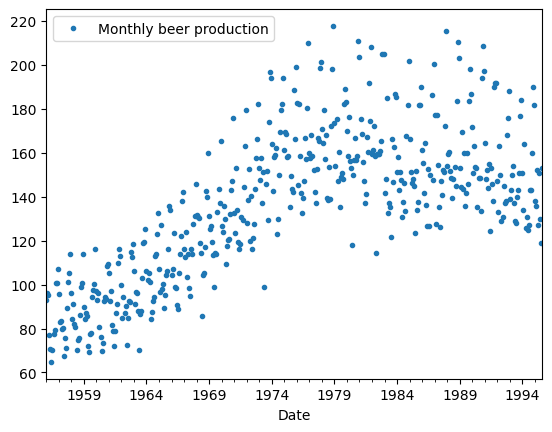

In [10]:
df.plot(x='Date',style='.')

<Axes: >

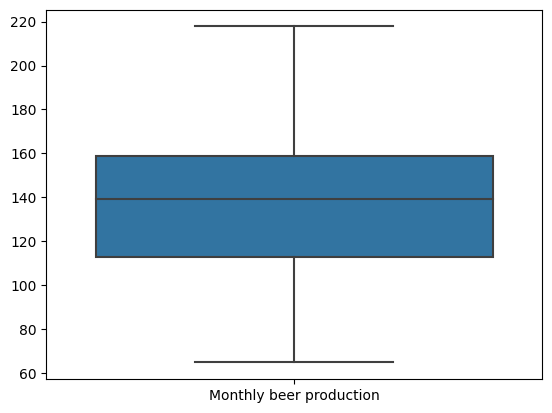

In [11]:
sns.boxplot(df)

In [12]:
df.corr()

,Monthly beer production,Date
Monthly beer production,1.000000,0.702349
Date,0.702349,1.000000


In [16]:
date = '01/01/1988'
train = df.loc[df['Date'] < date]
test = df.loc[df['Date'] >= date]

In [17]:
# Creating Features
train['Day'] = train['Date'].dt.day 
train['Month'] = train['Date'].dt.month 
train['Year'] = train['Date'].dt.year
train['Quarter'] = train['Date'].dt.quarter
train = train.drop('Date',axis=1)


test['Day'] = test['Date'].dt.day 
test['Month'] = test['Date'].dt.month 
test['Year'] = test['Date'].dt.year 
test['Quarter'] = test['Date'].dt.quarter
test = test.drop('Date',axis=1)

C:\Users\91978\AppData\Local\Temp\ipykernel_11016\675045949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Day'] = train['Date'].dt.day
C:\Users\91978\AppData\Local\Temp\ipykernel_11016\675045949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Month'] = train['Date'].dt.month
C:\Users\91978\AppData\Local\Temp\ipykernel_11016\675045949.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [18]:
xtrain = train.drop('Monthly beer production',axis=1)
xtest = test.drop('Monthly beer production',axis=1)

ytrain = train['Monthly beer production']
ytest = test['Monthly beer production']

In [28]:
model = xgboost.XGBRegressor(
    n_estimators=2000,
    early_stopping_rounds=50,
    learning_rate=0.01
    )

In [29]:
model.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xtest, ytest)], verbose=50)

[0]	validation_0-rmse:134.76246	validation_1-rmse:153.79241
[50]	validation_0-rmse:82.90785	validation_1-rmse:93.13146


[100]	validation_0-rmse:51.55280	validation_1-rmse:56.16845
[150]	validation_0-rmse:32.67403	validation_1-rmse:34.86070
[200]	validation_0-rmse:21.42043	validation_1-rmse:23.10142
[250]	validation_0-rmse:14.87013	validation_1-rmse:17.54167
[300]	validation_0-rmse:11.14535	validation_1-rmse:14.72639
[350]	validation_0-rmse:9.11777	validation_1-rmse:13.56405
[400]	validation_0-rmse:7.91010	validation_1-rmse:13.42553
[430]	validation_0-rmse:7.40679	validation_1-rmse:13.54054


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

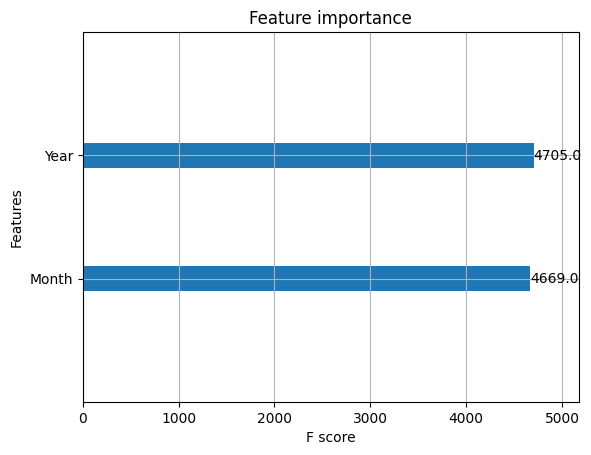

In [30]:
xgboost.plot_importance(model)

In [31]:
test['prediction'] = model.predict(xtest)

In [32]:
df_predicted = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

<Axes: xlabel='Date'>

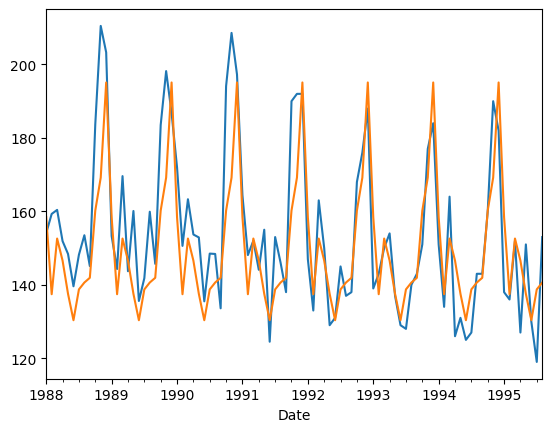

In [38]:
df_predicted = df_predicted.loc[~df_predicted['prediction'].isna()]
df_predicted.index = df_predicted['Date']
ax = df_predicted['Monthly beer production'].plot()
df_predicted['prediction'].plot(ax=ax)